In [1]:
import time
import copy
import torch
import torchvision
from torchvision import models

import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler

from load_models import load_mobilenet

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
dtype = torch.float32

cuda:0


# Fine Tune Model

In [10]:
def load_imagenette(path, bs=32):
    train_transforms = torchvision.transforms.Compose([
        #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
        #torchvision.transforms.RandomHorizontalFlip(),
        #torchvision.transforms.RandomRotation(20),
        torchvision.transforms.Resize(256),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    val_transforms= torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    train_path= path+'/train'
    imagenette_train = torchvision.datasets.ImageFolder(
        root=train_path,
        transform=train_transforms
    )
    print(len(imagenette_train))
    val_path=path+'/val'
    imagenette_val = torchvision.datasets.ImageFolder(
        root=val_path,
        transform=val_transforms
    )
    print(len(imagenette_val))

    train_loader = torch.utils.data.DataLoader(imagenette_train, num_workers=4,
                                              batch_size=bs,
                                              shuffle=True)
    val_loader = torch.utils.data.DataLoader(imagenette_val, num_workers=4,
                                              batch_size=bs,
                                              shuffle=True)
    return train_loader, val_loader

In [11]:
PATH = '/home/florian/data/imagenette2'
train_dl, val_dl = load_imagenette(PATH, 128)
dataloaders = {
    'train':train_dl, 
    'val':val_dl
}
dataset_sizes = {
    'train':len(train_dl.dataset), 
    'val':len(val_dl.dataset)
}


9469
3925


In [12]:
ims, labs = next(iter(train_dl))
ims.min(), ims.max()

(tensor(-2.1179), tensor(2.6400))

In [13]:
train_dl.dataset

Dataset ImageFolder
    Number of datapoints: 9469
    Root location: /home/florian/data/imagenette2/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [14]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                print(inputs.min(), inputs.max())
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, opt=None):
    max_loss = torch.zeros(y.shape[0]).cuda()
    max_delta = torch.zeros_like(X).cuda()
    lower_limit = 0.
    upper_limit = 1.
    for zz in range(restarts):
        delta = torch.zeros_like(X).cuda()
        print(len(epsilon))
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True
        for _ in range(attack_iters):
            output = model(X + delta)
            index = torch.where(output.max(1)[1] == y)
            if len(index[0]) == 0:
                break
            loss = F.cross_entropy(output, y)
            if opt is not None:
                loss.backward()
            else:
                loss.backward()
            grad = delta.grad.detach()
            d = delta[index[0], :, :, :]
            g = grad[index[0], :, :, :]
            d = clamp(d + alpha * torch.sign(g), -epsilon, epsilon)
            d = clamp(d, lower_limit - X[index[0], :, :, :], upper_limit - X[index[0], :, :, :])
            delta.data[index[0], :, :, :] = d
            delta.grad.zero_()
        all_loss = F.cross_entropy(model(X+delta), y, reduction='none').detach()
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
    return max_delta

def clamp(X, lower_limit, upper_limit):
    #print(upper_limit.shape)
    return torch.max(torch.min(X, upper_limit), lower_limit)

def _fit_fast_locuslab(model, train_loader, val_loader , epochs, device, alpha=10, eps = 8, number_of_replays=7, patience=None, evaluate_robustness=False):
    hist = []
    std = torch.tensor((1.,1.,1.)).view(3,1,1).cuda()
    epsilon = eps/255. / std
    alpha = alpha/255. / std
    pgd_alpha = (2 / 255.) / std
    lr_min = 0.
    lr_max = 1e-2
    lower_limit = 0.
    upper_limit = 1.
    momentum = .9
    weight_decay = 5e-4
    epochs = epochs
    print(epochs)
    model.train()
    
    
#    opt = torch.optim.SGD(model.parameters(), lr=lr_max, momentum=momentum, weight_decay=weight_decay)    
        
        
    criterion = nn.CrossEntropyLoss()
#    lr_steps = epochs * len(train_loader)

#    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=lr_min, max_lr=lr_max, step_size_up=lr_steps / 2, step_size_down=lr_steps / 2)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[lr_steps /(50-x) for x in range(50)], gamma=0.1)
    opt = optim.Adam(model.parameters(), lr=0.001)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        
    prev_robust_acc = 0. 
    state_dicts = []
    
    for epoch in range(epochs):
        print('start epoch:', epoch)
        start_epoch_time = time.time()       
        train_loss = 0
        train_acc = 0
        train_n = 0
        for i, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            if i == 0:
                #print('first batch',X.shape)
                first_batch = (X, y)
            delta = torch.zeros_like(X).cuda()
            #for j in range(len(epsilon)):
            #    if i == 0:
            #        delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
            #delta.data = clamp(delta, lower_limit - X, upper_limit - X)
            delta.requires_grad = True
            output = model(X + delta[:X.size(0)])
            loss = F.cross_entropy(output, y)
            loss.backward()
            grad = delta.grad.detach()
            delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
            delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
            delta = delta.detach()
            output = model(X + delta[:X.size(0)])
            loss = criterion(output, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss += loss.item() * y.size(0)
            train_acc += (output.max(1)[1] == y).sum().item()
            train_n += y.size(0)
        scheduler.step()
        X, y = first_batch
        #print('pre pgd',X.shape)
        pgd_delta = attack_pgd(model, X, y, epsilon, pgd_alpha, 20, 1, opt)
        with torch.no_grad():
            model.eval()
            output = model(clamp(X + pgd_delta[:X.size(0)], torch.tensor((0,0,0)).view(3,1,1).cuda(), torch.tensor((1,1,1)).view(3,1,1).cuda()))
            model.train()
        robust_acc = (output.max(1)[1] == y).sum().item() / y.size(0)
        #_, robust_acc = evaluate_pgd([(X,y)], model, 7,1)
        print(robust_acc, robust_acc - prev_robust_acc, robust_acc - prev_robust_acc < -0.2)
        hist.append(
            {
                'epoch':epoch+1,
                'clean accuracy':train_acc/train_n,
                'robust accuracy':robust_acc,
                'state dict': copy.deepcopy(model.state_dict())
            }
        )
        #if robust_acc - prev_robust_acc < -0.2:
            #break
        #print(robust_acc)
        if robust_acc >= prev_robust_acc:
            prev_robust_acc = robust_acc
            best_state_dict = copy.deepcopy(model.state_dict())
        state_dicts.append(copy.deepcopy(model.state_dict()))
        lr = scheduler.get_last_lr()[0]
        epoch_time = time.time()
        #print('epoch time:', start_epoch_time - epoch_time)
        print('epoch: ',epoch,', lr:',lr,', loss:', train_loss/train_n,', acc:', train_acc/train_n)
    print('training finished')
    
    model.load_state_dict(best_state_dict)
    model.eval()

    #print(evaluate_pgd(val_loader, model, 30, 3)[1])
    #print(evaluate_standard(val_loader, model)[1])

    return hist

# Construct Models

# Train Model

In [3]:
class ImageNetNormalization(nn.Module):
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        super(ImageNetNormalization, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return torchvision.transforms.functional.normalize(x, self.mean, self.std)

In [4]:
model = models.mobilenet_v3_small(pretrained=True)
num_ftrs_in = model.classifier[0].in_features
num_ftrs_out = model.classifier[0].out_features
model.classifier[0] = nn.Linear(num_ftrs_in, num_ftrs_out)

num_ftrs_in = model.classifier[3].in_features
num_ftrs_out = 10
model.classifier[3] = nn.Linear(num_ftrs_in, num_ftrs_out)

model = torch.nn.Sequential(
        ImageNetNormalization(),
        model
    )

In [5]:
model

Sequential(
  (0): ImageNetNormalization()
  (1): MobileNetV3(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (relu): ReLU(inplace=True)
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1),

## Mobilenet

In [17]:
def initialize_mobilenet(pretrained=True):
    model = models.mobilenet_v3_small(pretrained=pretrained)

    num_ftrs_in = model.classifier[0].in_features
    num_ftrs_out = model.classifier[0].out_features
    model.classifier[0] = nn.Linear(num_ftrs_in, num_ftrs_out)

    num_ftrs_in = model.classifier[3].in_features
    num_ftrs_out = 10
    model.classifier[3] = nn.Linear(num_ftrs_in, num_ftrs_out)

    model = torch.nn.Sequential(
        ImageNetNormalization(),
        model
    )
    return model


## Resnet

In [18]:
def initialize_resnet(pretrained=True):
    model = models.resnet18(pretrained=True)

    num_ftrs_in = model.fc.in_features
    num_ftrs_out = 10
    model.fc = nn.Linear(num_ftrs_in, num_ftrs_out)
    model = model.to(device)
    model = torch.nn.Sequential(
        #ImageNetNormalization(),
        model
    )
    return model

In [19]:
criterion = nn.CrossEntropyLoss()

In [21]:
model = initialize_resnet(pretrained=True).to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model,dataloaders, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
tensor(-2.1179, device='cuda:0') tensor(2.6400, device='cuda:0')
ten

KeyboardInterrupt: 

ResNet18 -- 96.3822% -- 9m 16

MobileNet V3 Small -- 97.1465% -- 9m 8s

In [13]:
MODEL_PATH = './models/ResNet18-wo-normalization-layer.pt'
torch.save(model.state_dict(), MODEL_PATH)

In [10]:
model = initialize_mobilenet(pretrained=False).to(device)
hist = _fit_fast_locuslab(
    model, 
    train_dl, 
    val_dl, 
    100, 
    device
)

100
start epoch: 0
3
0.0859375 0.0859375 False
epoch:  0 , lr: 0.001 , loss: 2.322100587223032 , acc: 0.09726475868623931
start epoch: 1
3
0.140625 0.0546875 False
epoch:  1 , lr: 0.001 , loss: 2.2179255637111375 , acc: 0.16221353891646426
start epoch: 2
3
0.265625 0.125 False
epoch:  2 , lr: 0.001 , loss: 2.12821639265225 , acc: 0.21311648537332348
start epoch: 3
3
0.265625 0.0 False
epoch:  3 , lr: 0.001 , loss: 1.998588346480719 , acc: 0.28419051642200865
start epoch: 4
3
0.1640625 -0.1015625 False
epoch:  4 , lr: 0.001 , loss: 1.7168091387012991 , acc: 0.40511141620023233
start epoch: 5
3
0.171875 -0.09375 False
epoch:  5 , lr: 0.001 , loss: 1.4107573910743512 , acc: 0.5320519590241842
start epoch: 6
3
0.046875 -0.21875 True
epoch:  6 , lr: 0.0001 , loss: 1.2219583612017602 , acc: 0.6048157144365826
start epoch: 7
3
0.0703125 -0.1953125 False
epoch:  7 , lr: 0.0001 , loss: 0.9623427558428685 , acc: 0.6842327595311015
start epoch: 8
3
0.0625 -0.203125 True
epoch:  8 , lr: 0.0001 , l

3
0.0703125 -0.1953125 False
epoch:  63 , lr: 1.0000000000000006e-12 , loss: 0.7071111916312321 , acc: 0.7662899989439222
start epoch: 64
3
0.09375 -0.171875 False
epoch:  64 , lr: 1.0000000000000006e-12 , loss: 0.683123390140044 , acc: 0.7743161896715598
start epoch: 65
3
0.1015625 -0.1640625 False
epoch:  65 , lr: 1.0000000000000006e-12 , loss: 0.7002858146277611 , acc: 0.7679797233076354
start epoch: 66
3
0.0703125 -0.1953125 False
epoch:  66 , lr: 1.0000000000000006e-12 , loss: 0.6980482489106673 , acc: 0.7744217974442918
start epoch: 67
3
0.0859375 -0.1796875 False
epoch:  67 , lr: 1.0000000000000006e-12 , loss: 0.6812043900360891 , acc: 0.7778012461717182
start epoch: 68
3
0.0625 -0.203125 True
epoch:  68 , lr: 1.0000000000000006e-12 , loss: 0.695340763082322 , acc: 0.7688245854894921
start epoch: 69
3
0.0859375 -0.1796875 False
epoch:  69 , lr: 1.0000000000000007e-13 , loss: 0.6870028195165634 , acc: 0.7733657197169712
start epoch: 70
3
0.0703125 -0.1953125 False
epoch:  70 , lr

KeyboardInterrupt: 

In [ ]:
model = initialize_mobilenet(pretrained=True).to(device)
hist = _fit_adv(
    model, 
    train_dl, 
    val_dl, 
    100, 
    device, 
    'PGD', 
    8, 
    patience=None
)

duration: 182 s - lr: 0.00000 - train loss: 1.44637 - train accuracy: 4.20 - validation loss: 2.25 - validation accuracy: 25.94 - validation robust accuracy: 0.00 
duration: 182 s - lr: 0.00001 - train loss: 1.44054 - train accuracy: 7.88 - validation loss: 2.21 - validation accuracy: 41.35 - validation robust accuracy: 0.03 
duration: 182 s - lr: 0.00001 - train loss: 1.40860 - train accuracy: 11.52 - validation loss: 2.16 - validation accuracy: 55.36 - validation robust accuracy: 0.00 
duration: 181 s - lr: 0.00001 - train loss: 1.37501 - train accuracy: 15.54 - validation loss: 2.06 - validation accuracy: 65.20 - validation robust accuracy: 0.00 
duration: 182 s - lr: 0.00001 - train loss: 1.34161 - train accuracy: 18.86 - validation loss: 1.90 - validation accuracy: 69.40 - validation robust accuracy: 0.00 
duration: 181 s - lr: 0.00001 - train loss: 1.27854 - train accuracy: 20.40 - validation loss: 1.55 - validation accuracy: 69.73 - validation robust accuracy: 0.13 


In [12]:
MODEL_PATH = './models/MobileNetV3Small-adv-trained.pt'
torch.save(model.state_dict(), MODEL_PATH)

In [15]:
_evaluate_model(model, val_dl, device, criterion=criterion)

(64.73885350318471, 1.1414369748484703)

In [16]:
evaluate_rob_accuracy(model, val_dl, device, 8, 'PGD')

10.318471337579618

In [19]:
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM
import time

def _evaluate_model(model, data_loader, device, criterion):
    correct = 0
    total = 0
    acc_loss = 0.0
    avg_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            #print(i)
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if criterion != None:
                loss = criterion(outputs, labels)
                acc_loss += loss.item() 
                avg_loss = acc_loss / (i+1)
            #print(outputs)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    model.train()
    return accuracy, avg_loss


def _craft_advs(model, images, labels, epsilon, attack, device):    
    #preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
    model.eval()
    fmodel = PyTorchModel(model, bounds=(0, 1), device=device)
    # apply the attack
    if attack == 'FGSM':
        attack = FGSM()
    if attack == 'PGD':
        attack = LinfPGD()
    
    raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilon)
    model.train()
    return clipped_advs

def evaluate_rob_accuracy(model, data_loader, device, epsilon, attack):
    correct = 0
    total = 0
    for i, data in enumerate(data_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        adv_images = _craft_advs(model, images, labels, epsilon, attack, device)
        adv_images, labels = adv_images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(adv_images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def _fit_adv(model, train_data, test_data, epochs, device, attack, epsilon, patience=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    scheduler = lr_scheduler.OneCycleLR(optimizer,max_lr=1e-4, total_steps=74*epochs)
    total_time = 0
    train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = [], [], [], []
    for epoch in range(epochs):  # loop over the dataset multiple times
        t0 = time.time()
        running_loss, acc_epoch_loss, avg_epoch_loss, epoch_accuracy, acc_epoch_accuracy = 0.0, 0.0, 0.0, 0.0, 0.0
        for i, data in enumerate(train_data, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            #if i == 0:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            adv_inputs = _craft_advs(model, inputs, labels, epsilon, attack, device)
            r = torch.randint(2, (128,))
            t = torch.empty(inputs.shape)
            for i in range(inputs.shape[0]):
                if r[i] == 1:
                    t[i,:,:,:] = inputs[i,:,:,:]
                else:
                    t[i,:,:,:] = adv_inputs[i,:,:,:]
            #combined_inputs = torch.cat((inputs, adv_inputs))
            #combined_labels = torch.cat((labels, labels))
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(t.to(device))
            #outputs = model(adv_inputs)
            _, predicted = torch.max(outputs.data, 1)
            #total = combined_labels.size(0)
            total = labels.size(0)
            #correct = (predicted == combined_labels).sum().item()
            correct = (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            loss = criterion(outputs, labels)
            #loss = criterion(outputs, combined_labels)
            loss.backward()
            optimizer.step()

                # print statistics
            running_loss += loss.item()
            acc_epoch_loss += running_loss
            avg_epoch_loss = acc_epoch_loss / (i+1)
            acc_epoch_accuracy += accuracy
            avg_epoch_accuracy = acc_epoch_accuracy / (i+1)
            scheduler.step()
            if i%10 == 0:
                print('[%d, %5d] loss: %.5f, train_accuracy: %.2f' %(epoch + 1, i + 1, running_loss, accuracy))
            running_loss = 0.0
        t1 = time.time()
        total_time +=t1-t0
        accuracy, loss = _evaluate_model(model, test_data, device, criterion)
        rob_acc = evaluate_rob_accuracy(model, test_data, device, epsilon, attack)
        lr = scheduler.get_last_lr()[0]
        print('duration: %d s - lr: %.5f - train loss: %.5f - train accuracy: %.2f - validation loss: %.2f - validation accuracy: %.2f - validation robust accuracy: %.2f ' %(t1-t0, lr, avg_epoch_loss, avg_epoch_accuracy, loss, accuracy, rob_acc))
        train_loss_hist.append(avg_epoch_loss)
        train_acc_hist.append(avg_epoch_accuracy)
        val_loss_hist.append(loss)
        val_acc_hist.append(accuracy)
    print('Finished Training')


    return train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist


In [29]:
model = initialize_mobilenet().to(device)

In [30]:
model

Sequential(
  (0): ImageNetNormalization()
  (1): MobileNetV3(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (relu): ReLU(inplace=True)
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          )
          (2): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1),

In [ ]:
delta = torch.zeros((2,))
for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())

In [ ]:
import numpy as np
np.linspace(0.0001,0.001, 20)

In [ ]:
def decay(lrs, v):
    if v<0.00001:
        return lrs
    else:
        lrs.append(v/1.05)
        lrs = decay(lrs, v/1.05)
    return lrs

In [ ]:
decayed_lrs = np.array(decay([],0.001))

In [ ]:
lrs = np.concatenate((np.linspace(0.0001,0.001, 20),decayed_lrs))

In [ ]:
x=0

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lrs)

In [127]:
a = torch.randn(4)
a
torch.clamp(a, min=-0.5, max=0.5)

min = torch.linspace(-1, 1, steps=4)
torch.clamp(a, min=min)

tensor([-0.0329,  0.8542,  0.7010,  1.0000])

In [130]:
torch.clamp(a, max=max)

tensor([1.0000, 0.5000])

In [129]:
max = torch.tensor((1,0.5)).float()

In [128]:
a = torch.tensor((1.,1.)) * 2

In [ ]:
def heatmap_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

model = nn.Linear(2, 2)
x = torch.randn(1, 2)
target = torch.randn(1, 2)
output = model(x)
loss = my_loss(output, target)
loss.backward()
print(model.weight.grad)

# Create Normal PGD Adversarial Examples

# Load Eye-tracking Heat Maps

In [3]:
import PIL, torch, torchvision
import numpy as np
from pathlib import Path
OCC_ONLY = Path('/home/florian/MT-Roxi/Occlusion_only')
IMGS = Path('/home/florian/MT-Roxi/images_scaled/')

OCC = Path('/home/florian/MT-Roxi/tobii_export/')

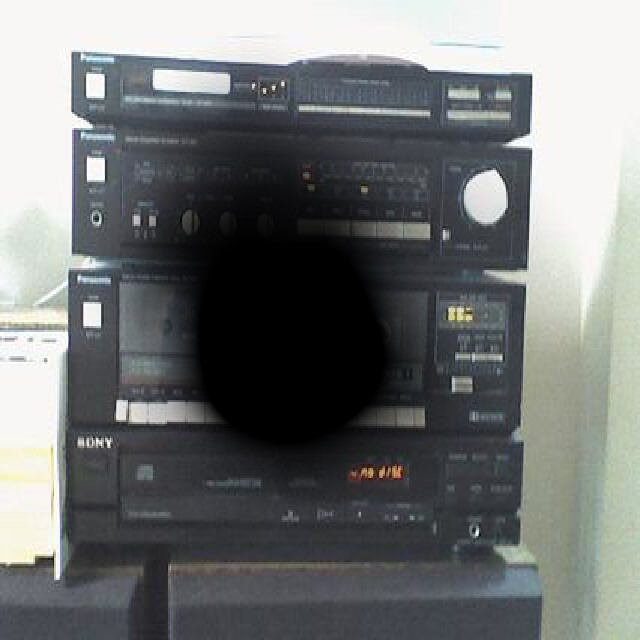

In [4]:
ex_img = list(sorted(OCC.iterdir()))[0]
img = PIL.Image.open(ex_img); img
#This is what we get from Tobii

In [5]:
img = img.resize((224,224))
x = np.asarray(img)

In [6]:
x.max()

255

In [177]:
x = np.transpose(x, (2,0,1))[3]/255
x.max()

1.0

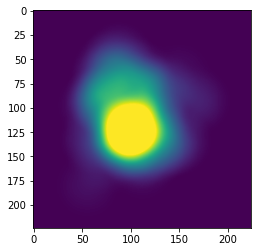

In [178]:
plt.imshow(mask)

In [183]:
clmp = 1 + 8/255 * x

In [186]:
for mask in sorted(OCC_ONLY.iterdir()):
    

IndentationError: expected an indented block (1167630041.py, line 1)

In [189]:
for img in sorted(IMGS.iterdir()):
    img = PIL.Image.open(img)
    img = np.asarray(img)/255
    print(np.max(img))

1.0
1.0
1.0
1.0
0.9882352941176471
1.0
1.0
1.0
1.0
1.0


In [184]:
def FGSM_step(model, inputs, heatmaps, labels, criterion, eps, device):

    inputs.retain_grad()
    perturbation = torch.zeros_like(inputs).to(device)
    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward(retain_graph=True)
    perturbation = torch.sign(inputs.grad).clamp_(-eps, eps)
    adv_examples = inputs + perturbation
    adv_examples.clamp_(0,1)
    return adv_examples, perturbation

In [ ]:
dist = max(x,x_) * (alpha * eth)

In [60]:
r = torch.randint(2, (128,))

In [50]:
b = next(iter(val_dl))

In [51]:
c =torch.zeros(b[0].shape)

In [62]:
torch.where(r == 0, b[0],c)

RuntimeError: The size of tensor a (128) must match the size of tensor b (224) at non-singleton dimension 3

In [73]:
r = torch.randint(2, (128,))
t = torch.empty(b[0].shape)
for i in range(b[0].shape[0]):
    if r[i] == 1:
        t[i,:,:,:] = b[0][i,:,:,:]
    else:
        t[i,:,:,:] = c[i,:,:,:]
        

In [74]:
t

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [75]:
r

tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1])